References:

https://pylessons.com/A2C-reinforcement-learning/
https://github.com/seungeunrho/minimalRL/blob/master/a2c.py
https://medium.com/deeplearningmadeeasy/advantage-actor-critic-a2c-implementation-944e98616b

In [117]:
import gym
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

from plot_durations import PlotDurations

In [118]:
##############################################################
# Memory
##############################################################
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward'))

class Memory(object):
    def __init__(self):
        self.memory = []

    def push(self, *args):
        self.memory.append(Transition(*args))

    def zip(self):
        return Transition(*zip(*self.memory))

    def clear(self):
        self.memory = []

    def __len__(self):
        return len(self.memory)

In [146]:
##############################################################
# Model
##############################################################
class ActorCritic(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(ActorCritic, self).__init__()
        self.activation = F.selu
        self.fc1 = nn.Linear(n_observations, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_actor = nn.Linear(256, n_actions)   # Q
        self.fc_critic = nn.Linear(256, 1)  # V

    def policy(self, x):  # actor
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = F.softmax(self.fc_actor(x), dim=0)
        return x

    def value(self, x):  # critic says how much reward the actor can take
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc_critic(x)
        return x

In [147]:
##############################################################
# Config
##############################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.0002
gamma         = 0.98

env = gym.make('CartPole-v1')
n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]

model = ActorCritic(n_observations, n_actions).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
memory = Memory()

In [148]:
##############################################################
# Training
##############################################################
def optimize_model():
    batch = memory.zip()
    state_batch = torch.tensor(batch.state, device=device, dtype=torch.float)
    action_batch = torch.tensor(batch.action, device=device).unsqueeze(1)  # [[0], [1], [0], [1], ...]

    R = 0
    reward_batch = list()
    for r in batch.reward[::-1]:
        R = r + gamma * R
        reward_batch.append(R)

    reward_batch = torch.tensor(reward_batch[::-1], device=device, dtype=torch.float)
    model_value = model.value(state_batch).reshape(-1)
    advantage = reward_batch - model_value

    policy_prob = model.policy(state_batch)
    policy_action_prob = policy_prob.gather(1, action_batch).reshape(-1)  # [[.2], [.3], ...]
    loss = -(torch.log(policy_action_prob) * advantage.detach()).mean() +\
        F.smooth_l1_loss(model.value(state_batch).reshape(-1), reward_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [149]:
episode_durations = []

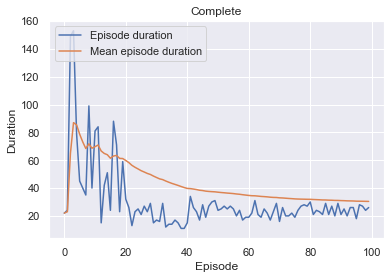

In [150]:
##############################################################
# Training loop
##############################################################
for n_epi in range(100):
    s = env.reset()
    done = False

    t = 0
    while not done:  # CartPole-v1 forced to terminates at 500 step.
        prob = model.policy(torch.tensor(s, device=device, dtype=torch.float))
        a = Categorical(prob).sample().item()
        s_prime, r, done, info = env.step(a)
        memory.push(s, a, r)
        s = s_prime
        t += 1

    episode_durations.append(t + 1)
    PlotDurations.train_plot(episode_durations)

    optimize_model()
    memory.clear()

env.close()
PlotDurations.complete_plot(episode_durations)

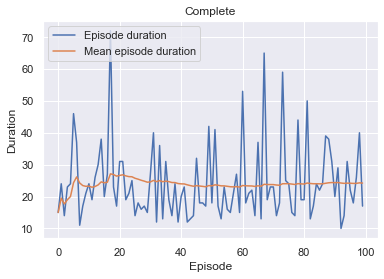

In [126]:
##############################################################
# Testing loop
##############################################################
episode_durations = []
model.eval()
for i_episode in range(100):
    s = env.reset()
    done = False

    t = 0
    while not done:
        prob = model.policy(torch.tensor(s, device=device, dtype=torch.float))
        a = Categorical(prob).sample()
        s_prime, r, done, info = env.step(a.item())
        s = s_prime
        t += 1

    episode_durations.append(t + 1)
    PlotDurations.train_plot(episode_durations)

env.close()
PlotDurations.complete_plot(episode_durations)